In [1]:
%%time
# Author: Michael Djaballah
# Last edited 01:15 AM July 6, 2020
# Last edited by: Michael Djaballah

import yfinance as yf
import pandas as pd
from datetime import datetime
import os
from time import sleep, time
from dateutil.relativedelta import relativedelta
import sklearn as sk
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from skorch import NeuralNetClassifier
from skorch import NeuralNetRegressor

CPU times: user 1.2 s, sys: 522 ms, total: 1.72 s
Wall time: 5.3 s


In [2]:
'''
Variable ordering
- Portfolio
- ticker(s)
- features
- model
- date
- date format
- historical depth
- training depth
- start
- end
- interval
- data path
'''

'\nVariable ordering\n- Portfolio\n- ticker(s)\n- features\n- model\n- date\n- date format\n- historical depth\n- training depth\n- start\n- end\n- interval\n- data path\n'

In [3]:
data_path = 'data/'
start = '2000-01-01'
interval = '1mo'

In [4]:
# Functions to maintain and call the S&P 500 from a current date
# Author Michael Djaballah
# Time last edited: 01:47 AM June 21, 2020
# Last edited by: Michael Djaballah

# Takes no input
# Output is newly saved CSV's containing the current makeup of the S&P 500 
# and its historical additions and removals
# data_path is changeable depending on desired save location
def get_snp_store(data_path='data/'):
    curr_raw = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    
    curr = curr_raw[0]
    hist = curr_raw[1]
    
    new_hist = pd.DataFrame(hist['Date'])
    new_hist['Added'] = hist['Added', 'Ticker']
    new_hist['Removed'] = hist['Removed', 'Ticker']
    
    os.makedirs(data_path, exist_ok=True)
    
    curr.to_csv(data_path + 'snp_current.csv', index=False)
    new_hist.to_csv(data_path + 'snp_hist.csv', index=False)
    return None


# Input: a date in string form with its corresponding format:
# Ex: 'January 1, 2020', '%B %d, %Y'
# Output: a list containing the S&P 500 at the input date
def build_snp(date, date_format='%Y-%m-%d', data_path='data/'):
#     get_snp_store(data_path=data_path)
    
    date_format2 = '%B %d, %Y'
    
    curr = pd.read_csv(data_path + 'snp_current.csv')
    hist = pd.read_csv(data_path + 'snp_hist.csv')
    
    start_date = datetime.strptime(date, date_format)
    
    snp_set = set(curr['Symbol'])
    
    for i in range(len(hist)):
        temp_date = datetime.strptime(hist.iloc[i]['Date'], date_format2)
        if temp_date < start_date:
            break

        tb_removed = hist.iloc[i]['Added']
        tb_added = hist.iloc[i]['Removed']

        if tb_removed in snp_set:
            snp_set.remove(tb_removed)
        if not type(tb_added) == float:
            snp_set.add(tb_added)
    
    return list(snp_set)

In [5]:
# Functions to obtain data from yfinance
# Author Michael Djaballah
# Time last edited: 01:47 AM June 21, 2020
# Last edited by: Michael Djaballah

# Takes a list of tickers as strings
# Output is newly saved CSV's with one CSV per company with daily data
# Saved in specific directory
# data_path is changeable depending on desired save location
def get_data(tickers, start='2000-01-01', data_path='data/', get_new=False):
    interval = '1d'
    prefix = interval + '/'
    
    os.makedirs(data_path + prefix, exist_ok=True)
    
    if get_new:
        curr_tickers = set()
    else:
        curr_tickers = set(os.listdir(data_path + prefix))
    
    for ticker in tickers:
        ticker_label = ticker + '.csv'
        
        if ticker_label not in curr_tickers:
            temp_ticker = yf.Ticker(ticker)
            temp_hist = temp_ticker.history(start=start, interval=interval)
            temp_hist.reset_index(inplace=True)
            temp_hist.dropna(axis=0, inplace=True)
            temp_hist.to_csv(data_path + prefix + ticker_label, index=False)
            sleep(.5)
            
    return None


# Input: Ticker 
# Output: Takes daily data already downloaded and extracts monthly data
# To be used with a set of other functions for intervals named "build_" + interval
# 
def build_1mo(ticker, data_path='data/'):
    if '.csv' in ticker:
        ticker_df = pd.read_csv(data_path + '1d/' + ticker)
    else:
        ticker_df = pd.read_csv(data_path + '1d/' + ticker + '.csv')
        
    date_format = '%Y-%m-%d'
    
    # These are hardcoded and should be more changed if more flexibility is desired
    data_start = '2000-01-01'
    data_end = '2020-05-01'
    
    month_list = list(pd.date_range(data_start, data_end, freq='MS').strftime(date_format))
    
    # Not currently coded for Dividends or Stock Splits
    months_dict = {
        'Date' : [], 
        'Open' : [], 
        'High' : [], 
        'Low' : [], 
        'Close' : [], 
        'Volume' : []
    }
    
    for start in month_list:
        end = datetime.strptime(start, date_format) + relativedelta(months=1) - relativedelta(days=1)
        end = datetime.strftime(end, date_format)
        
        month_df = ticker_df.set_index('Date')[start:end].reset_index()
        
        if len(month_df) > 0:
            months_dict['Date'].append(start)
            months_dict['Open'].append(month_df.iloc[0]['Open'])
            months_dict['High'].append(max(month_df['High']))
            months_dict['Low'].append(min(month_df['Low']))
            months_dict['Close'].append(month_df.iloc[-1]['Close'])
            months_dict['Volume'].append(sum(month_df['Volume']))
    
    months_df = pd.DataFrame.from_dict(months_dict)
    return months_df


# Input: Interval (string) that is in the list of approved
# Output: Data extracted from previously downloaded daily data in 
# a similarly named directory
# The commented out interval set is to be developed 
def build_data(interval, data_path='data/'):
#     interval_set = {'1mo', '5d', '1wk', '3mo'}
    interval_set = {'1mo'}
    if interval not in interval_set:
        print('Invalid interval')
        return -1
    
    prefix = interval + '/'
    
    os.makedirs(data_path + prefix, exist_ok=True)
    
    ticker_labels = os.listdir(data_path + '1d/')
    
    interval_function = globals()['build_' + interval]
    
    for ticker_label in ticker_labels:
        ticker_df = interval_function(ticker_label)
        ticker_df.to_csv(data_path + prefix + ticker_label, index=False)
    return None

In [6]:
# Functions to manipulate and extract desired data from data saved with "get_data"
# Author Michael Djaballah
# Time last edited: 01:47 AM June 21, 2020
# Last edited by: Michael Djaballah


# Takes a ticker as a string
# Output is either a dataframe with desired data, or False, indicating that there was not enough data to build with the desired offset
# data_path is changeable depending on desired save location
def check_ticker(ticker, offset, interval = '1mo', data_path='data/'):
    prefix = interval + '/'
    ticker_df = pd.read_csv(data_path + prefix + ticker + '.csv')
    if len(ticker_df) >= offset:
        return ticker_df
    return False


# Takes a list of tickers as strings, the test depth and historical depth
# Output is a dictionary of data frames: key = ticker string, value = dataframe
# data_path is changeable depending on desired save location
def build_portfolio(tickers, hist_depth, train_depth, start='2000-01-01', interval='1mo', data_path='data/', offset=True, get_new=False):
    if type(offset) == bool:
        offset = train_depth + hist_depth + 60 + 6
        
    prefix = interval + '/'
    
    get_data(tickers, data_path=data_path, start=start, get_new=get_new)
    
    ticker_dict = {}
    
    for ticker in tickers:
        ticker_df = check_ticker(ticker, offset, data_path=data_path)
        if type(ticker_df) != bool:
            ticker_dict[ticker] = ticker_df
    
    return ticker_dict


# Takes a portfolio (from 'build_portfolio'), a desired ticker, date desired to predict on, depth desired, and features desired
# Output is a dataframe with one row or the desired features from previous dates
# Can change 'keep_pred' to True if training or False if predicting
# Target value is present in 'Target' column if 'keep_pred' = True
def build_feature_vector(portfolio, ticker, features, date, hist_depth, target='Close', keep_pred=True):
    ticker_df = portfolio[ticker]
    
    start_date_dt = datetime.strptime(date, '%Y-%m-%d') - relativedelta(months=hist_depth)
    start_date = start_date_dt.strftime('%Y-%m-%d')
    
    remove_target = False
    
    if target not in features:
        remove_target = True
        features.append(target)
    
    feature_df = ticker_df.set_index('Date')[start_date:date].reset_index(drop=True)[features]
    
    new_df_dict = {}
    
    for i in range(len(feature_df)):
        for col in feature_df.columns:
            if i < len(feature_df) - 1:
                new_df_dict[col + ' ' + str(i + 1)] = [feature_df[col].iloc[i]]
            elif col == target:
                if keep_pred:
                    new_df_dict['Target'] = [feature_df[col].iloc[i]]
                    
    new_df = pd.DataFrame.from_dict(new_df_dict)
    
    if keep_pred:
        new_df = new_df[[col for col in new_df.columns if col not in {'Target'}] + ['Target']]
        
    if remove_target:
        new_df = new_df[[col for col in new_df.columns if not target in col]]
    
    return new_df

In [7]:
# 
# Author Michael Djaballah
# Time last edited: 01:15 AM July 6, 2020
# Last edited by: Michael Djaballah

# Input: portfolio, features, date that the training is to go to, both depths
# Output: dataframe with all features for all training months for the portfolio
# 
# 
def build_train_df(portfolio, features, date, hist_depth, train_depth, target='Close'):    
    tickers = portfolio.keys()
    
    vector_list = []
    for ticker in tickers:
        for i in range(train_depth):
            train_start_dt = datetime.strptime(date, '%Y-%m-%d') - relativedelta(months=(1+i))
            train_start = train_start_dt.strftime('%Y-%m-%d')
            vector_list.append(build_feature_vector(portfolio, ticker, features, train_start, hist_depth, target=target))
            
    feature_df = pd.concat(vector_list)
    return feature_df.reset_index(drop=True)


# Input: portfolio, features, date, historical depth
# Output: dataframe missing y's to predict with and an index list to show which ticker is where in the dataframe
# Returns in a tuple that must be unpacked
# 
def build_test_df(portfolio, features, date, hist_depth, target='Close'):
    tickers = portfolio.keys()
    
    vector_list = []
    index_list = []
    for ticker in tickers:
        vector_list.append(build_feature_vector(portfolio, ticker, features, date, hist_depth, target=target, keep_pred=False))
        index_list.append(ticker)
        
    test_df = pd.concat(vector_list)
    return test_df.reset_index(drop=True), index_list


# Input: portfolio, desired list of tickers to get returns for, and the date of those returns
# Output: list of returns for those tickers
# 
# 
def build_returns(portfolio, tickers, date):
    returns = []
    for ticker in tickers:
        temp_ticker_dict = portfolio[ticker].set_index('Date').loc[date]
        returns.append((temp_ticker_dict['Close'] - temp_ticker_dict['Open'])/temp_ticker_dict['Open'])
    return returns


# Input: Portfolio, ticker, and desired date 
# Output: Whether or not the data has the specific date
# This is to tell if a certain ticker exists on a certain date
# 
def check_date(portfolio, ticker, date):
    dates = set(portfolio[ticker]['Date'])
    return date in dates


# Input: Portfolio, date
# Output: None, this directly edits the portfolio
# This can be changed to reduce side effects, but it is used 
# to remove tickers that are no longer needed moving forward in a backtest
def clean_portfolio(portfolio, date):
    tickers = list(portfolio.keys())
    bad_tickers = []
    for ticker in tickers:
        if not check_date(portfolio, ticker, date):
            bad_tickers.append(ticker)
    for bad_ticker in bad_tickers:
        del portfolio[bad_ticker]
    return None


# ALERT: This function has been depracated as direct access to the scaler is needed for interpretation
# Input: Dataframe
# Output: Dataframe scaled to standard
# 
# 
# def build_scaled_df(dataframe):
#     scaler = StandardScaler()
#     scaled_array = scaler.fit_transform(dataframe)
#     scaled_dataframe = pd.DataFrame(scaled_array, columns=dataframe.columns)
#     return scaled_dataframe


# Input: Portfolio, date
# Output: Dataframe of 'Close 1', the close of the previous month for the whole portfolio
# 
# 
def build_previous_close(portfolio, date):
    tickers = portfolio.keys()
    
    vector_list = []
    index_list = []
    for ticker in tickers:
        vector_list.append(build_feature_vector(portfolio, ticker, ['Close'], date, hist_depth=1, keep_pred=False))
        index_list.append(ticker)
        
    df = pd.concat(vector_list)
    return df.reset_index(drop=True)


# Input: Portfolio, model, date, features, and depths
# Output: 
# 
# 
def build_machine(portfolio, features, model, date, hist_depth, train_depth, target='Close'):
    train_df = build_train_df(portfolio, features, date, hist_depth, train_depth, target=target)
    use_scaling = True
    
    X = train_df.loc[:, train_df.columns != 'Target'].values
    y = train_df['Target'].values
    
    # For neural nets in Pytorch
    if 'skorch' in str(type(model)):
        X = X.astype('float32')
        y = y.astype('float32')
        
        y = y.reshape(-1, 1)
        
        if 'classifier' not in str(type(model)):
            scaler_y = StandardScaler()
            scaler_y.fit(y)
            y = scaler_y.transform(y)
    
    scaler_X = StandardScaler()
    
    scaler_X.fit(X)
    
    X = scaler_X.transform(X)
    
    model.fit(X, y)
    
    test_df, tickers = build_test_df(portfolio, features, date, hist_depth, target=target)
    X_test = test_df.values
    
    # For neural nets in Pytorch
    if 'skorch' in str(type(model)):
        X_test = X_test.astype('float32')
    
    X_test = scaler_X.transform(X_test)
    
    predicted_returns = model.predict(X_test)
    predicted_returns = np.ravel(predicted_returns)
    
    previous_close = build_previous_close(portfolio, date)['Close 1'].values
        
    if use_scaling:
        predicted_returns = (predicted_returns - previous_close)/previous_close
    
    predicted_returns = list(predicted_returns)
    
    returns_dict = {}
    
    for i in range(len(tickers)):
        returns_dict[tickers[i]] = predicted_returns[i]
    
    return returns_dict


# Input: Returns dictionary and fixed long short parameters
# Output: Allocation dictionary for long and short tickers
# 
# 
def fixed_long_short(returns_dict, long=15, short=0):
    allocation = {
        'long' : [], 
        'short' : []
    }
    top = sorted(returns_dict.items(), key=lambda x: x[1])[::-1]
    sorted_tickers = [x[0] for x in top]
    
    if long == 0:
        allocation['long'] == []
    else:
        allocation['long'] = sorted_tickers[:long]
    if short == 0:
        allocation['short'] = []
    else:
        allocation['short'] = sorted_tickers[-1 * short:]
#     print('long: ')
#     print(allocation['long'])
#     print('short: ')
#     print(allocation['short'])
    
    return allocation
    

# Input: all things needed to build a machine with a date range to test
# Output: per date average returns as determined by the model
# 
# 
def backtest(portfolio, features, model, hist_depth, train_depth, start_date, end_date, 
             allocation_builder=fixed_long_short, params={}, blacklist=set(), 
             target='Close'):
    
    use_scaling=True
    
    months = list(pd.date_range(start_date, end_date, freq='MS').strftime('%Y-%m-%d'))
    
    for ticker in blacklist:
        if ticker in portfolio:
            del portfolio[ticker]
            
    portfolio = deepcopy(portfolio)
    
    overall_returns = []
    specific_returns = []
    for month in months:
        start_time = time()
        
        clean_portfolio(portfolio, month)
        
        returns_dict = build_machine(portfolio, features, model, month, hist_depth, train_depth, target=target)
        
        allocation = allocation_builder(returns_dict, **params)
        
        long_returns = build_returns(portfolio, allocation['long'], month)
        short_returns = build_returns(portfolio, allocation['short'], month)
        short_returns = [short_return * -1 for short_return in short_returns]
        total_returns = long_returns + short_returns
        average_returns = sum(total_returns)/len(total_returns)
        
        
        specific_returns_dict = {'long': {}, 'short': {}}
        for i in range(len(allocation['long'])):
            specific_returns_dict['long'][allocation['long'][i]] = long_returns[i]

        for i in range(len(allocation['short'])):
            specific_returns_dict['short'][allocation['short'][i]] = short_returns[i]
            
        specific_returns.append(specific_returns_dict)
        overall_returns.append(average_returns)
        
        print(month, round(average_returns, 5), round(time() - start_time, 2))
        
    build_documentation(
        portfolio, 
        features, 
        model, 
        hist_depth, 
        train_depth, 
        start_date, 
        end_date, 
        allocation_builder=allocation_builder, 
        params=params, 
        blacklist=blacklist, 
        target=target, 
        returns=overall_returns, 
        specific_ret=specific_returns
    )
    
    return overall_returns, specific_returns

In [8]:
# METRICS
# Author Michael Djaballah
# Time last edited: 05:31 PM July 12, 2020
# Last edited by: Michael Djaballah


def cumulative_returns(returns):
    starting_capital = 1
    historical_returns = [starting_capital]
    for i in range(len(returns)):
        starting_capital *= (returns[i] + 1)
        historical_returns.append(starting_capital)
    return historical_returns


def total_return(cumulative_returns):
    return cumulative_returns[-1]


def return_volatility(returns):
    return np.std(returns)
    

def max_drawdown(cumulative_returns):
    drawdowns = []
    for i in range(len(cumulative_returns)):
        for j in range(i+1, len(cumulative_returns)):
            drawdowns.append((cumulative_returns[i] - cumulative_returns[j])/cumulative_returns[i])
    return max(drawdowns)


def min_amount(cumulative_returns):
    return min(cumulative_returns)


def annualized_returns(returns,  unit=1/12, tot_return=None):
    if type(tot_return) != float:
        cumul_returns = cumulative_returns(returns)
        tot_return = total_return(cumul_returns)
    years = len(returns) * unit
    return tot_return**(1/years)


def sharpe_ratio(returns):
    return np.sqrt(12) * np.mean(returns)/np.std(returns)


# Input: Whole portfolio and date of backtest
# Output: List of returns
# This list is the average return of the entire portfolio long 
# 
def universe_backtest(portfolio, start_date, end_date):
    months = list(pd.date_range(start_date, end_date, freq='MS').strftime('%Y-%m-%d'))
    
    returns = []
    
    portfolio = deepcopy(portfolio)
    
    for month in months:
        clean_portfolio(portfolio, month)
        monthly_returns = build_returns(portfolio, list(portfolio.keys()), month)
        returns.append(sum(monthly_returns)/len(monthly_returns))
    return returns

In [9]:
# DOCUMENTATION
# Author Michael Djaballah
# Time last edited: 05:31 PM July 12, 2020
# Last edited by: Michael Djaballah

# Input: all inputs associated with a backtest
# Output: 2 timestamped spreadsheets in the results folder
# A standard sheet and a specific sheet 
# The standard sheet comparing to the S&P500 and the specific with detailed holdings

def build_documentation(portfolio, features, model, hist_depth, train_depth, start_date, end_date, 
             allocation_builder, params, blacklist, returns, specific_ret, target='Close',
                       tickers = None):
    path = 'results/'
    if not tickers:
        tickers = list(portfolio.keys())
    
    cumul_returns = cumulative_returns(returns)
    return_vol = return_volatility(returns)
    total_returns = total_return(cumul_returns)
    ann_returns = annualized_returns(returns, tot_return=total_returns)
    max_draw = max_drawdown(cumul_returns)
    min_balance = min_amount(cumul_returns)
    sharpe = sharpe_ratio(returns)
    
    docu_dict = {
        'tickers' : [tickers], 
        'features' : [features], 
        'model' : [str(model)], 
        'hist_depth' : [hist_depth], 
        'train_depth' : [train_depth], 
        'start_date' : [start_date], 
        'end_date' : [end_date], 
        'allocation_builder' : [str(allocation_builder)], 
        'params' : [params], 
        'blacklist' : [blacklist], 
        'target' : [target], 
        'returns' : [returns], 
        'cumulative returns' : [cumul_returns], 
        'total return' : [total_returns], 
        'sharpe ratio' : [sharpe], 
        'annualized return' : [ann_returns],
        'return volatility' : [return_vol], 
        'max drawdown' : [max_draw], 
        'minimum' : [min_balance]
    }
    
    docu_df = pd.DataFrame.from_dict(docu_dict)
    docu_df = docu_df.T
    docu_df.columns = ['Portfolio']
    
    os.makedirs(path, exist_ok=True)
    
    # This checks for stored S&P500 results and generates them if not
    if 'snp.csv' not in set(os.listdir(path)):
        snp_returns = universe_backtest(portfolio, start_date=start_date, end_date=end_date)
        
        snp_cumul = cumulative_returns(snp_returns)
        snp_vol = return_volatility(snp_returns)
        snp_total = total_return(snp_cumul)
        snp_ann = annualized_returns(snp_returns, tot_return=snp_total)
        snp_max_draw = max_drawdown(snp_cumul)
        snp_min_balance = min_amount(snp_cumul)
        snp_sharpe = sharpe_ratio(snp_returns)
        print(snp_sharpe)

        snp_dict = {
            'tickers' : ['N/A'], 
            'features' : ['N/A'], 
            'model' : ['N/A'], 
            'hist_depth' : ['N/A'], 
            'train_depth' : ['N/A'], 
            'start_date' : [start_date], 
            'end_date' : [end_date], 
            'allocation_builder' : ['N/A'], 
            'params' : ['N/A'], 
            'blacklist' : [blacklist], 
            'target' : ['N/A'], 
            'returns' : [snp_returns], 
            'cumulative returns' : [snp_cumul], 
            'total return' : [snp_total], 
            'sharpe ratio' : [snp_sharpe], 
            'annualized return' : [snp_ann],
            'return volatility' : [snp_vol], 
            'max drawdown' : [snp_max_draw], 
            'minimum' : [snp_min_balance]
        }
        
        snp_df = pd.DataFrame.from_dict(snp_dict)
        snp_df = snp_df.T
        snp_df.columns = ['S&P']
        
        snp_df.to_csv(path + 'snp.csv')
    
    snp_df = pd.read_csv(path + 'snp.csv', index_col=0)
    
    tot_df = docu_df.join(snp_df)
    
    print(tot_df)
    
    label = str(datetime.now())
    
    tot_df.to_csv(path + label + '.csv')
    
    spec_df = specific_returns_df(specific_ret, start_date, end_date)
    spec_df.to_csv(path + 'specific_' + label + '.csv')
    
    snp_cumul = [float(x) for x in snp_df.loc['cumulative returns'][0].replace('[', '').replace(']', '').split(', ')]
    
    # 
    df_dict = {'S&P': snp_cumul, 'Port': cumul_returns}
    compare_df = pd.DataFrame.from_dict(df_dict)

    fig_dims = (20,10)
    fig, ax = plt.subplots(figsize=fig_dims)
    sns.lineplot(data=compare_df)
    plt.show()
    
    print()
    print('Specifics on the backtest can be found at: ' + path + 'specific_' + label + '.csv')
    return None


# Input: a specific returns/results dictionary output from backtest
# Output: a refactored view of returns in dataframe form
# 
# 
def specific_returns_df(specific_results, start_date, end_date):
    months = list(pd.date_range(start_date, end_date, freq='MS').strftime('%Y-%m-%d'))

    specific_dict = {}
    for i in range(len(months)):
        specific_dict[months[i]] = [specific_results[i]['long'], specific_results[i]['short']]

    spec_df = pd.DataFrame.from_dict(specific_dict)
    spec_df = spec_df.T
    spec_df.columns = ['long', 'short']
    return spec_df

In [10]:
# MULTI ALPHA
# Author: Michael Djaballah
# Time last edited: August 10, 2020
# Last edited by: Michael Djaballah

# Example of single obs of spec ret
"""
{'long': {'CHK': 0.425,
  'FTR': -0.14529914529914525,
  'JEF': 0.2131681877444589,
  'AVP': 0.5743243243243243,
  'QEP': 0.5063757016989476,
  'THC': 0.3034973325429755,
  'PBI': 0.23248871279830471,
  'AMZN': 0.17303439803439802,
  'DNR': 0.23030303030303026,
  'MU': 0.23290322580645156,
  'IVZ': 0.1095334685598378,
  'SYK': 0.13916449086161894,
  'UNM': 0.2191323692992215,
  'GAS': 0.019744483159117306,
  'ISRG': 0.11531416400425983},
 'short': {}}
 """

# Backtest params
"""
portfolio
features
model
hist_depth
train_depth
start_date
end_date
allocation_builder
params 
blacklist 
target
"""

# Docu params
"""
portfolio, 
features, 
model, 
hist_depth, 
train_depth, 
start_date, 
end_date, 
allocation_builder, 
params, 
blacklist, 
returns, 
specific_ret, 
target
"""

def multi_backtest(backtest_list):
    all_returns = []
    all_specific_returns = []
    
    for backtest_params in backtest_list:
        temp_tup = backtest(**backtest_params)
        all_returns.append(temp_tup[0])
        all_specific_returns.append(temp_tup[1])
    
    all_returns = np.array(all_returns)
    returns = [np.mean(ret_list) for ret_list in all_returns.T]
    
    specific_returns = []
    for j in range(len(all_specific_returns[0])):
        spec_temp = {
            'long' : {}, 
            'short' : {}
        }
        
        for i in range(len(all_specific_returns)):
            for long in all_specific_returns[i][j]['long']:
                if long in spec_temp['long']:
                    if long[-1].isdigit():
                        spec_temp['long'][long + str(int(long[-1]) + 1)] = all_specific_returns[i][j]['long'][long[:-1]]
                else:
                    spec_temp['long'][long] = all_specific_returns[i][j]['long'][long]
            
            for short in all_specific_returns[i][j]['short']:
                if short in spec_temp['short']:
                    if short[-1].isdigit():
                        spec_temp['short'][short + str(int(short[-1]) + 1)] = all_specific_returns[i][j]['short'][short[:-1]]
                else:
                    spec_temp['short'][short] = all_specific_returns[i][j]['short'][short]
        
        specific_returns.append(spec_temp)
        
    tickers = []
    features = []
    models = []
    hist_depths = []
    train_depths = []
    allocation_builders = []
    other_params = []
    blacklists = []
    targets = []
    for params in backtest_list:
        tickers.append(params['portfolio'].keys())
        features.append(params['features'])
        models.append(params['model'])
        hist_depths.append(params['hist_depth'])
        train_depths.append(params['train_depth'])
        allocation_builders.append(params['allocation_builder'])
        other_params.append(params['params'])
        blacklists.append(params['blacklist'])
        targets.append(params['target'])
        
    start_date = backtest_list[0]['start_date']
    end_date = backtest_list[0]['end_date']
    
    portfolio = {}
    
    build_documentation(
        portfolio, 
        features, 
        models, 
        hist_depths, 
        train_depths, 
        start_date, 
        end_date, 
        allocation_builder=allocation_builders, 
        params=other_params, 
        blacklist=blacklists, 
        target=targets, 
        returns=returns, 
        specific_ret=specific_returns,
        tickers=tickers
    )
    return returns, specific_returns

In [11]:
# CLASSIFIER
# Author Michael Djaballah
# Time last edited:  PM July 19, 2020
# Last edited by: Michael Djaballah

# Buckets definition
# Dictionary of buckets and values that determine what  an observation will be labled
# Simple buckets of 0 or 1 for positive or negative results:
buckets_temp = {
    'buckets' : [0], 
    'values' : [0, 1]
}
# We have length n buckets and n + 1 class values 
# Anything lower than or equal to a threshold gets assigned that number


# Input: dataframe and buckets
# Output: classes or modified original dataframe
# 
# 
def build_return_classes(df, buckets={'buckets' : [0], 'values' : [0, 1]}, inplace=False):
    values = buckets['values']
    buckets = buckets['buckets']
    
    returns = []
    for i in range(len(df)):
        returns.append((df.iloc[i]['Close'] - df.iloc[i]['Open'])/df.iloc[i]['Open'])
    
    classes = []
    m = len(buckets)
    for i in range(len(returns)):
        for j in range(len(buckets)):
            if returns[i] <= buckets[j]:
                classes.append(values[j])
                break
            elif j == m - 1:
                classes.append(values[j + 1])
    if inplace:
        df['Classes'] = classes
        return None
    return classes


# Input: portfolio and buckets 
# Output: modfies original portfolio to added classes
# 
# 
def build_classes(port, buckets={'buckets' : [0], 'values' : [0, 1]}):
    tickers = list(port.keys())
    
    for ticker in tickers:
        build_return_classes(port[ticker], buckets=buckets, inplace=True)
    
    return None

In [12]:
# NEURAL NETS
# Author Michael Djaballah
# Time last edited:  PM July 27, 2020
# Last edited by: Michael Djaballah
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class RegressorModule(nn.Module):
    def __init__(
        self,
        in_dim,
        l1 = 30, 
        l2 = 30, 
        l3 = 10, 
        l4 = 5
    ):
        super(RegressorModule, self).__init__()
        self.l1 = nn.Linear(in_dim, l1)
        self.l2 = nn.Linear(l1, l2)
        self.l3 = nn.Linear(l2, l3)
        self.l4 = nn.Linear(l3, l4)
        self.l5 = nn.Linear(l4, 1)
        
    def forward(self, x):
        x = F.selu(self.l1(x))
        x = F.selu(self.l2(x))
        x = F.selu(self.l3(x))
        x = F.selu(self.l4(x))
        x = F.selu(self.l5(x))
        return x


class ClassifierModule(nn.Module):
    def __init__(
        self,
        in_dim,
        l1 = 30, 
        l2 = 30, 
        l3 = 10, 
        l4 = 5
    ):
        super(ClassifierModule, self).__init__()
        self.l1 = nn.Linear(in_dim, l1)
        self.l2 = nn.Linear(l1, l2)
        self.l3 = nn.Linear(l2, l3)
        self.l4 = nn.Linear(l3, l4)
        self.l5 = nn.Linear(l4, 1)
        
    def forward(self, x):
#         x = F.selu(self.l1(x))
#         x = F.selu(self.l2(x))
#         x = F.selu(self.l3(x))
#         x = F.selu(self.l4(x))
#         x = F.softmax(self.l5(x))
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = F.softmax(self.l5(x))
        return x

In [13]:
#function to construct technical: W%R
#input: dataframe(df) that stores the data with Close Price, 
#       interval, a int to specify the W%R period length, default = 30(most common period)
#       new = True for returning a new df deepcopy, new = False for no deepcopy
#output: df, with updated feature W%R


def build_WpercentR(df, interval=30, new = False): 
    if new == True:
        df = copy.deepcopy(df)
    
    col_name='W%R'+str(interval)
    
    starting=interval
    
    #initialization        
    df[col_name]=0
    if starting >= len(df):
        print('no enough data for constructing W%R'+str(interval))
        return df

    for i in range(starting, len(df)):
        #
        
        maxi=df['High'][(i-interval):i].max()
        mini=df['Low'][(i-interval):i].min()
                
        WR=-100*(maxi-df['Close'][i-1])/(maxi-mini)
        df.loc[i,col_name]=WR
    
    return df

In [14]:
%%time
# Took 2 secs
# get_snp_store()
universe = build_snp('2015-01-01')

CPU times: user 45.6 ms, sys: 1.94 ms, total: 47.6 ms
Wall time: 48.6 ms


In [15]:
%%time
# Took 13 mins 20 secs
# get_data(universe)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [16]:
%%time
# Took 2 min 41 secs for S&P 2015-01-01
# build_data('1mo')

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


In [28]:
hist_depth = 6
train_depth = 6
features = ['Close', 'Volume']
start_date = '2015-01-01'
end_date = '2019-12-01'
params = {
    'long' : 25, 
    'short' : 0
}
target = 'Close'
total_features = len(features) * hist_depth

In [29]:
%%time
port2 = build_portfolio(universe, hist_depth, train_depth)
print(len(port2.keys()))

440
CPU times: user 988 ms, sys: 64.8 ms, total: 1.05 s
Wall time: 1.21 s


In [30]:
buckets = {
    'buckets' : [0], 
    'values' : [-1, 1]
}

In [31]:
%%time
# Took 32 secs
# for ticker in port2.keys():
# build_WpercentR(port2[ticker])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [32]:
print(port2[ticker].columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [33]:
%%time
# Took 35 secs
# build_classes(port2, buckets)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


In [34]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier

In [35]:
rfr = RandomForestRegressor(n_estimators=100, random_state=410, n_jobs=-1)
gbr = GradientBoostingRegressor(n_estimators=100, random_state=407)
rfc = RandomForestClassifier(random_state=407, n_jobs=-1)

In [36]:
net_regr = NeuralNetRegressor(
    RegressorModule(total_features),
    lr = .1,
    device=device,
    max_epochs=5
)

net_class = NeuralNetClassifier(
    ClassifierModule(total_features),
    lr =.1,
    device=device
)

In [37]:
model = rfr

2015-01-01 -0.02585 11.24
2015-02-01 0.05243 12.08
2015-03-01 -0.05418 14.96
2015-04-01 -0.0032 14.11
2015-05-01 0.0065 12.3
2015-06-01 -0.04772 12.9
2015-07-01 -0.0805 13.4
2015-08-01 0.16584 12.07
2015-09-01 -0.04153 12.26
2015-10-01 0.25766 11.82
2015-11-01 -0.02649 11.48
2015-12-01 -0.03188 12.85
2016-01-01 -0.07677 13.64
2016-02-01 0.00179 13.28
2016-03-01 0.25099 11.73
2016-04-01 0.00323 11.46
2016-05-01 0.03097 11.75
2016-06-01 0.01061 11.45
2016-07-01 0.05303 11.12
2016-08-01 0.02936 11.21
2016-09-01 0.02865 11.47
2016-10-01 -0.05502 11.37
2016-11-01 0.11319 11.77
2016-12-01 0.0061 11.32
2017-01-01 0.01669 15.89
2017-02-01 0.00391 14.96
2017-03-01 -0.02335 12.37
2017-04-01 -0.03164 11.77
2017-05-01 -0.02279 12.12
2017-06-01 0.00432 11.85
2017-07-01 -0.00521 11.46
2017-08-01 -0.0275 11.49
2017-09-01 0.07566 11.33
2017-10-01 0.00339 11.54
2017-11-01 0.04491 11.36
2017-12-01 0.0067 11.34
2018-01-01 0.03538 11.27
2018-02-01 -0.0569 11.26
2018-03-01 0.0964 11.12
2018-04-01 0.0176 11

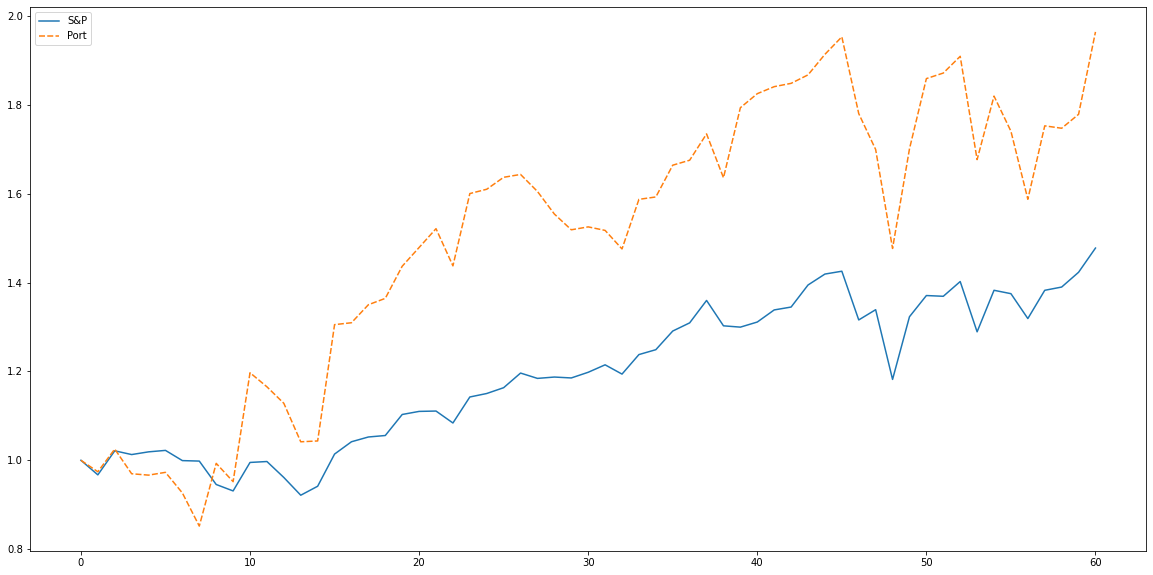


Specifics on the backtest can be found at: results/specific_2020-10-09 20:17:37.334685.csv
CPU times: user 14min 26s, sys: 6.23 s, total: 14min 32s
Wall time: 12min 4s


In [38]:
%%time
results, specific_results = backtest(
    port2, 
    features,
    model, 
    hist_depth, 
    train_depth, 
    start_date, 
    end_date, 
    params=params, 
    target=target
)

In [31]:
# Backtest params
"""
portfolio
features
model
hist_depth
train_depth
start_date
end_date
allocation_builder
params 
blacklist 
target
"""

port3 = deepcopy(port2)

backtest_list = [
    {
        'portfolio' : port2, 
        'features' : ['Close', 'Volume'], 
        'model' : rfr, 
        'hist_depth' : 6, 
        'train_depth' : 6, 
        'start_date' : '2015-01-01', 
        'end_date' : '2019-12-01',
        'allocation_builder' : fixed_long_short, 
        'params' : {
            'long' : 15, 
            'short' : 0
        }, 
        'blacklist' : {}, 
        'target' : 'Close'
    }, 
    {
        'portfolio' : port3, 
        'features' : ['Close', 'Volume'], 
        'model' : gbr, 
        'hist_depth' : 12, 
        'train_depth' : 12, 
        'start_date' : '2015-01-01', 
        'end_date' : '2019-12-01',
        'allocation_builder' : fixed_long_short, 
        'params' : {
            'long' : 0, 
            'short' : 15
        }, 
        'blacklist' : {}, 
        'target' : 'Close'
    }
]

2015-01-01 -0.02361 9.12
2015-02-01 0.08261 9.32
2015-03-01 -0.09201 9.14
2015-04-01 0.01115 9.37
2015-05-01 0.01243 9.03
2015-06-01 -0.0482 9.02
2015-07-01 -0.13953 9.2
2015-08-01 0.28324 9.31
2015-09-01 -0.04921 9.28
2015-10-01 0.35334 8.96
2015-11-01 -0.04033 9.15
2015-12-01 -0.00166 9.27
2016-01-01 -0.05814 9.08
2016-02-01 -0.05091 9.03
2016-03-01 0.31777 9.08
2016-04-01 0.00532 9.07
2016-05-01 0.04958 9.21
2016-06-01 -0.02124 9.43
2016-07-01 0.06511 9.36
2016-08-01 0.02364 9.18
2016-09-01 -0.00444 9.32
2016-10-01 -0.0476 9.06
2016-11-01 0.13645 9.1
2016-12-01 -0.0038 9.06
2017-01-01 0.05212 9.1
2017-02-01 0.01266 9.4
2017-03-01 -0.02893 9.14
2017-04-01 -0.05609 9.32
2017-05-01 -0.05606 9.1
2017-06-01 -0.01856 9.47
2017-07-01 -0.01106 9.41
2017-08-01 -0.04693 9.37
2017-09-01 0.08999 9.33
2017-10-01 -0.00617 9.09
2017-11-01 0.03063 9.37
2017-12-01 0.00269 9.28
2018-01-01 0.05057 9.33
2018-02-01 -0.0646 9.48
2018-03-01 0.1625 9.38
2018-04-01 0.04161 9.27
2018-05-01 0.04756 8.98
2018-

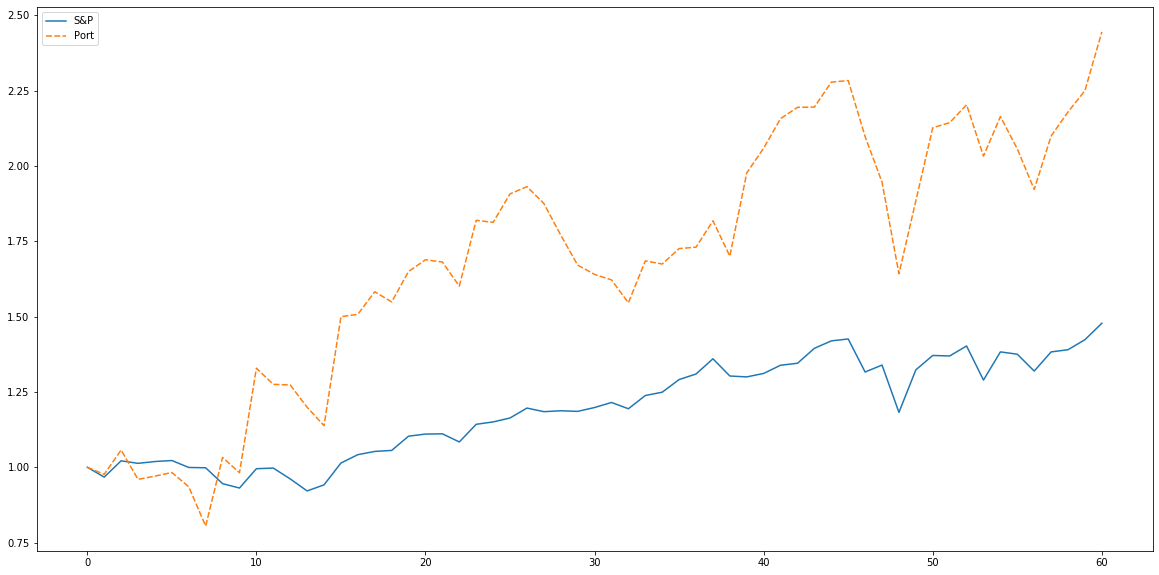


Specifics on the backtest can be found at: results/specific_2020-08-17 18:40:07.997253.csv


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [32]:
tup_res = multi_backtest(backtest_list)

In [49]:
cumul_port = cumulative_returns(results)
vol_port = return_volatility(results)
tot_port = total_return(cumul_port)
draw_port = max_drawdown(cumul_port)
min_port = min_amount(cumul_port)
ann_port = annualized_returns(results)
# print('Cumulative: ', cumul_spy)
print('Vol: ', vol_port)
print('Total: ', tot_port)
print('Max draw: ', draw_port)
print('Min: ', min_port)
print('Ann ret: ', ann_port)

NameError: name 'results' is not defined

In [25]:
%%time
spy_ret = universe_backtest(port2, start_date=start_date, end_date=end_date)
cumul_spy = cumulative_returns(spy_ret)
vol_spy = return_volatility(spy_ret)
tot_spy = total_return(cumul_spy)
draw_spy = max_drawdown(cumul_spy)
min_spy = min_amount(cumul_spy)
ann_spy = annualized_returns(spy_ret)
# print('Cumulative: ', cumul_spy)
print('Vol: ', vol_spy)
print('Total: ', tot_spy)
print('Max draw: ', draw_spy)
print('Min: ', min_spy)
print('Ann ret: ', ann_spy)

Vol:  0.038396414135841134
Total:  1.5350555976772664
Max draw:  0.17021046203761483
Min:  0.944038989437292
Ann ret:  1.0894939474860266
CPU times: user 11.6 s, sys: 7.75 ms, total: 11.6 s
Wall time: 11.6 s


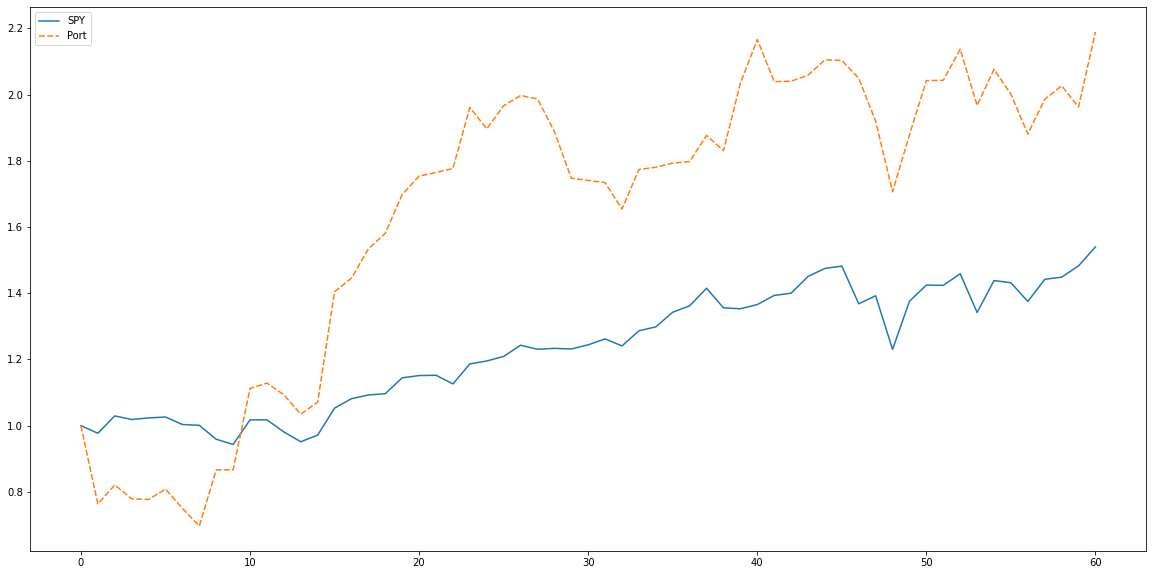

In [20]:
df_dict = {'SPY': cumul_spy, 'Port':cumul_port}
compare_df = pd.DataFrame.from_dict(df_dict)

fig_dims = (20,10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(data=compare_df)

In [21]:
months = list(pd.date_range(start_date, end_date, freq='MS').strftime('%Y-%m-%d'))
month_dict = {}
for i in range(len(months)):
    month_dict[months[i]] = i

In [37]:
suspect_month = '2019-01-01'

In [38]:
specific_results[month_dict[suspect_month]]

{'long': {'CHK': 0.425,
  'FTR': -0.14529914529914525,
  'JEF': 0.2131681877444589,
  'AVP': 0.5743243243243243,
  'QEP': 0.5063757016989476,
  'THC': 0.3034973325429755,
  'PBI': 0.23248871279830471,
  'AMZN': 0.17303439803439802,
  'DNR': 0.23030303030303026,
  'MU': 0.23290322580645156,
  'IVZ': 0.1095334685598378,
  'SYK': 0.13916449086161894,
  'UNM': 0.2191323692992215,
  'GAS': 0.019744483159117306,
  'ISRG': 0.11531416400425983},
 'short': {}}

In [24]:
# port2['THC'].tail(30)

In [ ]:
# For hist=12, train=3, took 7s
# %%time
# build_train_df(port2, features, '2015-01-01', hist_depth, train_depth)

In [ ]:
# For hist=12, train=3, took 2s
# %%time
# test_df, ticker_list = build_test_df(port2, features, '2015-01-01', hist_depth)

In [77]:
# starting_capital = 100
# historical = [starting_capital]
# for i in range(len(results)):
#     starting_capital *= (results[i] + 1)
#     historical.append(starting_capital)

In [78]:
# historical[-1], (historical[-1]/100)**(1/5), min(historical)

(272.54411874587106, 1.2220454628915778, 66.82568275184586)

In [79]:
# spy = yf.Ticker('SPY').history(period='max', interval='1mo').reset_index().dropna()
# port3 = {'SPY': spy}
# months = list(pd.date_range(start_date, end_date, freq='MS').strftime('%Y-%m-%d'))

# starting_capital = 100
# historical_spy = [starting_capital]
# for month in months:
#     returns = build_returns(port3, ['SPY'], month)[0]
#     starting_capital *= (returns + 1)
#     historical_spy.append(starting_capital)
    
# df_dict = {'SPY': historical_spy, 'Port':historical}
# compare_df = pd.DataFrame.from_dict(df_dict)

In [80]:
# historical_spy[-1], (historical_spy[-1]/100)**(1/5), min(historical_spy)

(149.72619165922305, 1.0840755652449479, 93.8068232860004)